Este script abre varios ficheros netCDF, lee una variable OCEANIQUE y despues selectionamos las estaciones del anio, calculo de medias estacionales, de anuales y hacemos un indice sobre un dominio, con masqueado y sin masqueado.

## Choose the kernel env_emis_gloenv39 (already created by ES)

### Add this environment to your jupyter kernel 

./installa_env39.sh

close and reopen the notebook to see the new kernel env_emis_gloenv39 and use it

### Delete the environment from your jupyter kernel
jupyter kernelspec list

jupyter kernelspec uninstall env_emis_gloenv39

In [1]:
# import xarray, numpy and pandas 
import xarray as xr
import numpy as np
import pandas as pd

import time as tm

from pylab import *

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker

import seaborn as sns

# import plotting modules 
from matplotlib.colors import BoundaryNorm
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.path as mpath

from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


%matplotlib inline

/data/softs/anaconda3-2020.07/envs/gloenv_py3.9/lib/python3.9/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
## Parametres d'entree

varname = 'tos'   #'tos'
vartype = 'Omon' #! La variable nommée 'type' existe déjà dans Python, on ne souhaite pas la modifier.
model = 'CNRM-ESM2-1'
expe = 'historical' 
grid = 'gn'

fyear_in = 1850
lyear_in = 2014

fyear_out=1960 #periode de traitement pour les donnees
lyear_out=2014

# Domaine spatial
basin = 'atl'

nbmonth = 12
month_name = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
nbseason = 4
#season = ['JFM', 'AMJ', 'JAS', 'OND']
season = ['DJF','MAM','JJA','SON']

# Plots features
#plot_type = 'png'
#plt.rcParams.update({'font.size': 20}) #augmenter la taille de la police pour toutes les figures

#Mask file
infile_msk = "/data/scratch/globc/dcom/CMIP6_TOOLS/xESMF_Interpolation/masks_eorca1.nc"

#Input/Output
indir = '/data/scratch/globc/dcom/CMIP6/CMIP/CNRM-CERFACS/'+model+'/'+expe+'/r*/'+vartype+'/'+varname+'/'+grid+'/latest/'
infile = varname+'_*'
outdir ='/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/'
outfile= varname+'_index_'+model+'_'+expe+'_'+str(fyear_out)+'_'+str(lyear_out)+'_'+basin+'.nc'
outfile
#figdir = outdir
#figfile = 'plot2D_clim_'+varname+'_'+expe+'_'+str(fyear_out)+'_'+str(lyear_out)

'tos_index_CNRM-ESM2-1_historical_1960_2014_atl.nc'

In [3]:
# -- Lecture du fichier
ds = xr.open_mfdataset(indir+infile,engine='netcdf4', concat_dim='ensemble', combine='nested', chunks={'time': 1980})
#ds.info() #youpiiii!
fld = ds[varname]

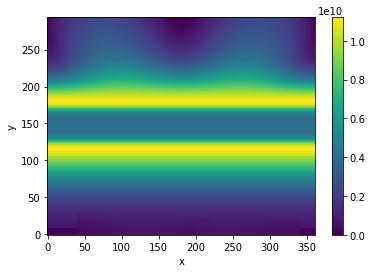

In [4]:
# -- Lecture masques et facteurs d'echelle NEMO
ds_msk= xr.open_mfdataset(infile_msk)
tmask_2d_dom = ds_msk["tmask"+basin]
e1t = ds_msk["e1t"]
e2t = ds_msk["e2t"]
# -- Calcul de l'area
area = e1t[0] * e2t[0]
area.plot()

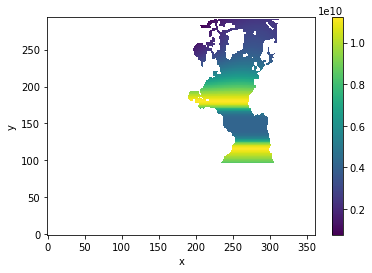

In [5]:
# -- Input d'Aurelien
m=xr.open_dataset(infile_msk)
masked_area = xr.where(m.get('tmask'+basin)==1., m.e1t[0]*m.e2t[0], np.nan)
masked_area.plot()

In [6]:
# -- On selectionne une periode de temps pour le calcul
fld_sel = fld.sel(time=slice(str(fyear_out)+'-01-01', str(lyear_out)+'-12-31'))

In [7]:
# -- On define des fonctions qui permettent de masquer les donnees NEMO

def mask_field(data, mask = None):
    _mask = mask
    return data.where(_mask == 1.)

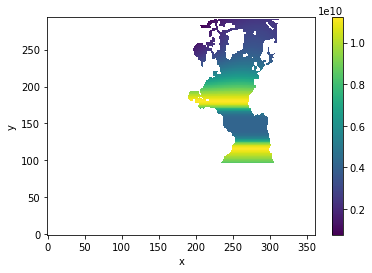

In [8]:
# -- On masque et on selectionne la region d'etude
fld_msk = mask_field(fld_sel, mask=tmask_2d_dom)
area_msk = mask_field(area,mask=tmask_2d_dom)
area_msk.plot() # Ca marche!!

<xarray.DataArray 'tos' (ensemble: 10, time: 660)>
dask.array<truediv, shape=(10, 660), dtype=float64, chunksize=(1, 660), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1960-01-16T12:00:00 ... 2014-12-16T12:00:00
Dimensions without coordinates: ensemble

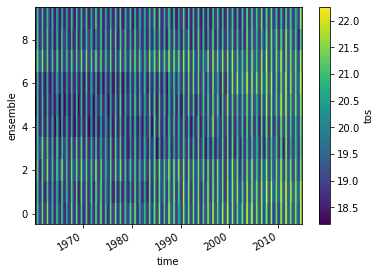

In [9]:
index = fld_msk.weighted(area_msk.fillna(0.)).mean(dim=('x', 'y'))
index.plot()
index

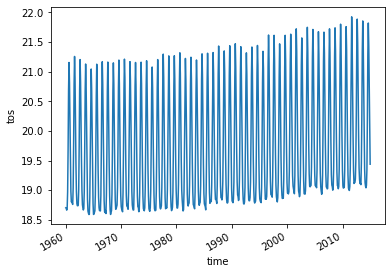

In [10]:
# - Moyenne ensemble indice
index_em=index.mean(dim='ensemble').compute()
index_em.plot()

In [11]:
## - On garde tout dans un fichier netCDF
ds = xr.Dataset({'index': (("member","time"),index.values)},
                attrs = {
                    'creation_date': tm.strftime('%d/%m/%Y'),
                    'script_name': 'compute_ClimStd_2D_1file_atmos.ipynb',
                })
    
output  = outdir + outfile
ds.to_netcdf(output)